<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Assignment-3:-Word2Vec" data-toc-modified-id="Assignment-3:-Word2Vec-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Assignment 3: Word2Vec</a></span><ul class="toc-item"><li><span><a href="#Documents-represented-as-term-frequency-matrix" data-toc-modified-id="Documents-represented-as-term-frequency-matrix-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Documents represented as term-frequency matrix</a></span><ul class="toc-item"><li><span><a href="#Learn-the-vocabulary-from-the-entire-dataset" data-toc-modified-id="Learn-the-vocabulary-from-the-entire-dataset-1.1.1"><span class="toc-item-num">1.1.1&nbsp;&nbsp;</span>Learn the vocabulary from the entire dataset</a></span></li><li><span><a href="#Learn-the-vocabulary-only-from-the-labelled-data" data-toc-modified-id="Learn-the-vocabulary-only-from-the-labelled-data-1.1.2"><span class="toc-item-num">1.1.2&nbsp;&nbsp;</span>Learn the vocabulary only from the labelled data</a></span></li></ul></li><li><span><a href="#Documents-represented-as-word2vec-vectors" data-toc-modified-id="Documents-represented-as-word2vec-vectors-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Documents represented as word2vec vectors</a></span><ul class="toc-item"><li><span><a href="#Preprocess-data" data-toc-modified-id="Preprocess-data-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Preprocess data</a></span></li><li><span><a href="#Create-word2vec-vectors" data-toc-modified-id="Create-word2vec-vectors-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Create word2vec vectors</a></span></li><li><span><a href="#Obtain-accuracy-scores" data-toc-modified-id="Obtain-accuracy-scores-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Obtain accuracy scores</a></span></li></ul></li><li><span><a href="#Plot" data-toc-modified-id="Plot-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Plot</a></span></li></ul></li></ul></div>

# Assignment 3: Word2Vec

In this assignment, we will see how we can use Word2Vec (or any similar word embedding) to use information from unlabelled data to help us classify better!

You will be using the sentiment data from last week, either the yelps or movies, whichever you wish. 

Your goal will be to simulate the following situation: you have a **small** set of labelled data and a large set of unlabelled data. Show how the two follow 2 techniques compare as the amount of labelled data increases. You should train them on the small labelled subset and test their performance on the rest of the data. 

In other words, train on 1k, test on 99k. Then train on 2k, test on 98k. Then train on 4k, test on 96k. Etc.

1. Logistic regression trained on labelled data, documents represented as term-frequency matrix of your choice. You can learn the vocabulary from the entire dataset or only the labelled data.

2. Logistic regression trained on the labelled data, documents represented as word2vec vectors where you train word2vec using the entire dataset. Play around with different settings of word2vec (training window size, K-negative, skip-gram vs BOW, training windows, etc.). Note: we didn't go over the options in detail in class, so you will need to read about them a bit!

You can read about the gensime word2vec implementation [here](https://radimrehurek.com/gensim/models/word2vec.html).

## Documents represented as term-frequency matrix 

In [127]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [128]:
import nltk
import matplotlib.pyplot as plt
import re
import spacy
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.naive_bayes import MultinomialNB
from IPython.display import display, Math, Latex
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.decomposition import TruncatedSVD, PCA
import itertools
import  pyarrow
import warnings
warnings.filterwarnings(action='once')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr" 
from gensim.models import Word2Vec
from gensim.test.utils import common_texts, get_tmpfile

In [129]:
yelps = pd.read_csv('yelps.csv').sample(frac=1.)

# fix wrong labels
l = list(yelps[(yelps['positive']== "positive")].positive.index)
for i in l: 
    yelps.loc[i,'positive'] = "True"
yelps.head()

,business_id,positive,text
36520,VoTi4yVhTVyFdmxUpoyUsg,True,I literally got the plane and came straight he...
15148,XMhUSc1d_XySrtdiF5lpqQ,False,I've been going here for years. It has really...
42500,S5FTckOpSK0_Ma4c18ZEgg,False,This place was recommended to me by a fellow c...
31073,z6O2P8bZ9SAqPyjVIl_Dyg,False,This is unbelievable! I was just charged a 30 ...
24666,AMsfjpim5WohOzQJOtLyQg,True,It was my first time there and I will defiantl...


### Learn the vocabulary from the entire dataset

In [130]:
# learn the vocabulary from the entire yelps dataset
vectorizer = TfidfVectorizer(min_df=20,
                             max_df=.6,
                             max_features=2000,
                             stop_words ='english',
                             use_idf=True)

In [131]:
# Create feature matrix and y for classification model
V = vectorizer.fit_transform(yelps.text)
V.shape
V = np.asarray(V.todense())
y = yelps.positive

In [188]:
# create lregr
# lregr = LogisticRegression(penalty='l2', C=100.0, fit_intercept=True,  max_iter=500, intercept_scaling=1,solver="liblinear")
lregr = LogisticRegression();

# "fitting" of logistic model 
size = np.linspace(0, 1, 100,endpoint=False)[1:51]
# auc_full = [] # Consdiering data is reasonably balanced, we don't really need this
TF_score_full = []
score_full = []
for s in size:
    V_train, V_test, y_train, y_test = train_test_split(V, y, train_size = s, random_state = 0)
    lregr.fit(V_train,y_train);
#     y_pred = lregr.predict_proba(V_test)
#     auc = roc_auc_score(y_true = y_test, y_score = y_pred[:,1])
#     auc_full.append(auc)
    TF_score = lregr.score(V_test,y_test);
    TF_score_full.append(TF_score)
TF_score_full    

[0.9048715695483975,
 0.9187371815148516,
 0.927445542921353,
 0.9306896659479391,
 0.9329600117891014,
 0.9354595066114911,
 0.9373676117974689,
 0.9379476756192733,
 0.938826192543103,
 0.9395464595624591,
 0.9399795512510815,
 0.9407747463154665,
 0.9409215774168707,
 0.941664825645617,
 0.9421549827653142,
 0.9422877754365916,
 0.9426888184764406,
 0.942855749179908,
 0.9431132180289619,
 0.9436396135144932,
 0.9441540194676151,
 0.944143173980488,
 0.9445735880420243,
 0.9450942725945028,
 0.9452021919123235,
 0.9448941259138143,
 0.945509088667589,
 0.9458078135633238,
 0.9462698759207357,
 0.9459451737782666,
 0.9462197295769749,
 0.9468405805626222,
 0.94676357775025,
 0.9471228144601679,
 0.9471400879972924,
 0.9476266366676042,
 0.9475730929176851,
 0.947824263733428,
 0.947936133241533,
 0.9481517282757241,
 0.9481542998542423,
 0.9484155718768318,
 0.9481246272060629,
 0.948001857076533,
 0.9486927748081888,
 0.9487241213288397,
 0.9484736425040564,
 0.9484442906042075,
 0.

Text(0.5, 1.0, 'Accuracy Scores of Method 1 - a')

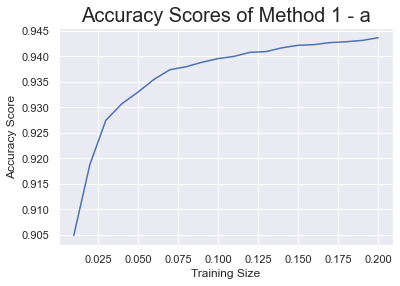

In [133]:
sns.set()
plt.plot(size, TF_score_full)
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.title("Accuracy Scores of Method 1 - a", fontsize = 20)

### Learn the vocabulary only from the labelled data

In [134]:
TF_score_test = []
for s in size:
    V_train, V_test, y_train, y_test = train_test_split(yelps.text, y, train_size= s , random_state=0)
    V_train = vectorizer.fit_transform(V_train)
    V_test = vectorizer.transform(V_test)
    lregr.fit(V_train, y_train)
    score_LR = lregr.score(V_test,y_test)
    TF_score_test.append(score_LR)
TF_score_test

[0.8927911275415896,
 0.9152270848851566,
 0.9253631330989763,
 0.9296584481734946,
 0.9326021283538415,
 0.9353531270278608,
 0.9366902142941625,
 0.9376976837711813,
 0.9386064195685857,
 0.9392686910436319,
 0.9399009022167792,
 0.9409565582991489,
 0.9410365159822075,
 0.941513668127856,
 0.9423902685787561,
 0.9423949144673405,
 0.9426285796898908,
 0.9426728290428399,
 0.94310087280718,
 0.9435146182018175]

Text(0.5, 1.0, 'Accuracy Scores of Method 1 - b')

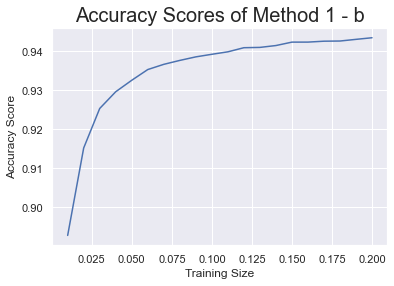

In [135]:
sns.set()
plt.plot(size, TF_score_test)
plt.xlabel('Training Size')
plt.ylabel('Accuracy Score')
plt.title("Accuracy Scores of Method 1 - b", fontsize = 20)

## Documents represented as word2vec vectors

### Preprocess data

In [73]:
# nlp = spacy.load('en_core_web_sm')
# def preprocess(docs):
#     new_docs = []
    
#     for doc in docs:  
#         doc = re.sub(re.compile('[^(\w|\s)]') , '', doc)
#         words = [token.lemma_ for token in nlp(doc) if token.lemma_ != '-PRON-']
#         doc = " ".join(words).lower()
#         new_docs.append(doc)
#     return np.array(new_docs) 

# yelps_processed = yelps.copy()
# new_yelps = preprocess(yelps.text.values)
# yelps_processed["text"] = new_yelps
# yelps_processed.to_parquet('yelps_processed.parquet.gzip',compression='gzip')

<>:6: DeprecationWarning: invalid escape sequence \w


In [136]:
new_yelps = pd.read_parquet("yelps_processed.parquet.gzip")
new_yelps

,business_id,positive,text
32841,uuGL8diLlHfeUeFuod3F-w,False,this place be terrible be pretty empty and sig...
99073,yW9IIc1cBIlFlbOG_1pp_Q,True,do fantastic sandwich at lunch pick from any b...
56913,thLX_k20SPJ0KyusGTBIHw,False,will not be come back to this place only get a...
66930,oGefwIDMrFmSg9aBkv_T1Q,False,the place be overprice agree with most of the ...
68009,5bLqyDPyatWFhoFGRgjEDA,True,honest show up on time professional efficient ...
...,...,...,...
35914,_9SDJqTh8z0t3WZmVvbnYA,False,try to call and no answer \n at 545 \n 24 hrs ...
12390,duVuU_LzYwjdd9LNbCgnyw,False,well go into planet fitness today to re activa...
56832,HkbNItNrnXlNo59M0YyoMg,True,be visit a friend in az who bring here to grab...
80039,R6cjtlmUW_8hV4AlPTp99A,False,this be mom experience have use this practic...


In [137]:
words_list = [text.split() for text in new_yelps.text]

### Create word2vec vectors

In [148]:
# transform one piece of text 
def one_embed(word_vecs, text):
    vec = np.zeros(word_vecs.vector_size)
    for word in text:
        try: 
            vec = vec + word_vecs.get_vector(word)
        except: 
            pass
    vec_norm = vec / np.linalg.norm(vec)
    return vec_norm

# transform all texts
def embed_all(word_vecs, texts):
    all_embedded = np.empty(shape = (len(texts), word_vecs.vector_size))
    for i, text in enumerate(texts):
        all_embedded[i] = one_embed(word_vecs, text)
    return(all_embedded)


In [149]:
# define model, need to fine tune parameters
w2v = Word2Vec(words_list, min_count=0, size=100, window = 15)
w2v.train(words_list, total_examples=len(words_list), epochs= 10)
word_vecs = w2v.wv
docs_emb = embed_all(word_vecs, words_list)

/Users/yaping/opt/anaconda3/envs/gse/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


In [150]:
# replace NA with 0
V_emb = np.array(pd.DataFrame(docs_emb).fillna(0)) 

### Obtain accuracy scores

In [152]:
w2c_score = []
for s in size:
    V_train, V_test, y_train, y_test = train_test_split(V_emb, new_yelps["positive"], train_size= s , random_state=0)    
    lregr.fit(V_train, y_train) 
    score = lregr.score(V_test,y_test)
    w2c_score.append(score)
w2c_score

[0.9278809733038392,
 0.934308133424487,
 0.9386410729565065,
 0.941616407820589,
 0.9427281243750197,
 0.9439166835101007,
 0.9449050030644173,
 0.9455561231698967,
 0.946452314758854,
 0.9466240014221748,
 0.947035493185623,
 0.9475017897117144,
 0.9479443237589509,
 0.9480018138902131,
 0.9483194710774914,
 0.9486327869242765,
 0.9485681240437093,
 0.9489896711095935,
 0.9491500314803155,
 0.9495393922727897]

## Plot

In [182]:
zippedList =  list(zip(TF_score_full, TF_score_test, w2c_score))
df = pd.DataFrame(zippedList, columns = ['TF1' , 'TF2', 'w2c']) 
df.index = size
df.head()

,TF1,TF2,w2c
0.01,0.904872,0.892791,0.927881
0.02,0.918737,0.915227,0.934308
0.03,0.927446,0.925363,0.938641
0.04,0.930690,0.929658,0.941616
0.05,0.932960,0.932602,0.942728


[Text(0, 0.5, 'Scores'),
 Text(0.5, 0, 'Training size'),
 Text(0.5, 1.0, 'Accuracy scores')]

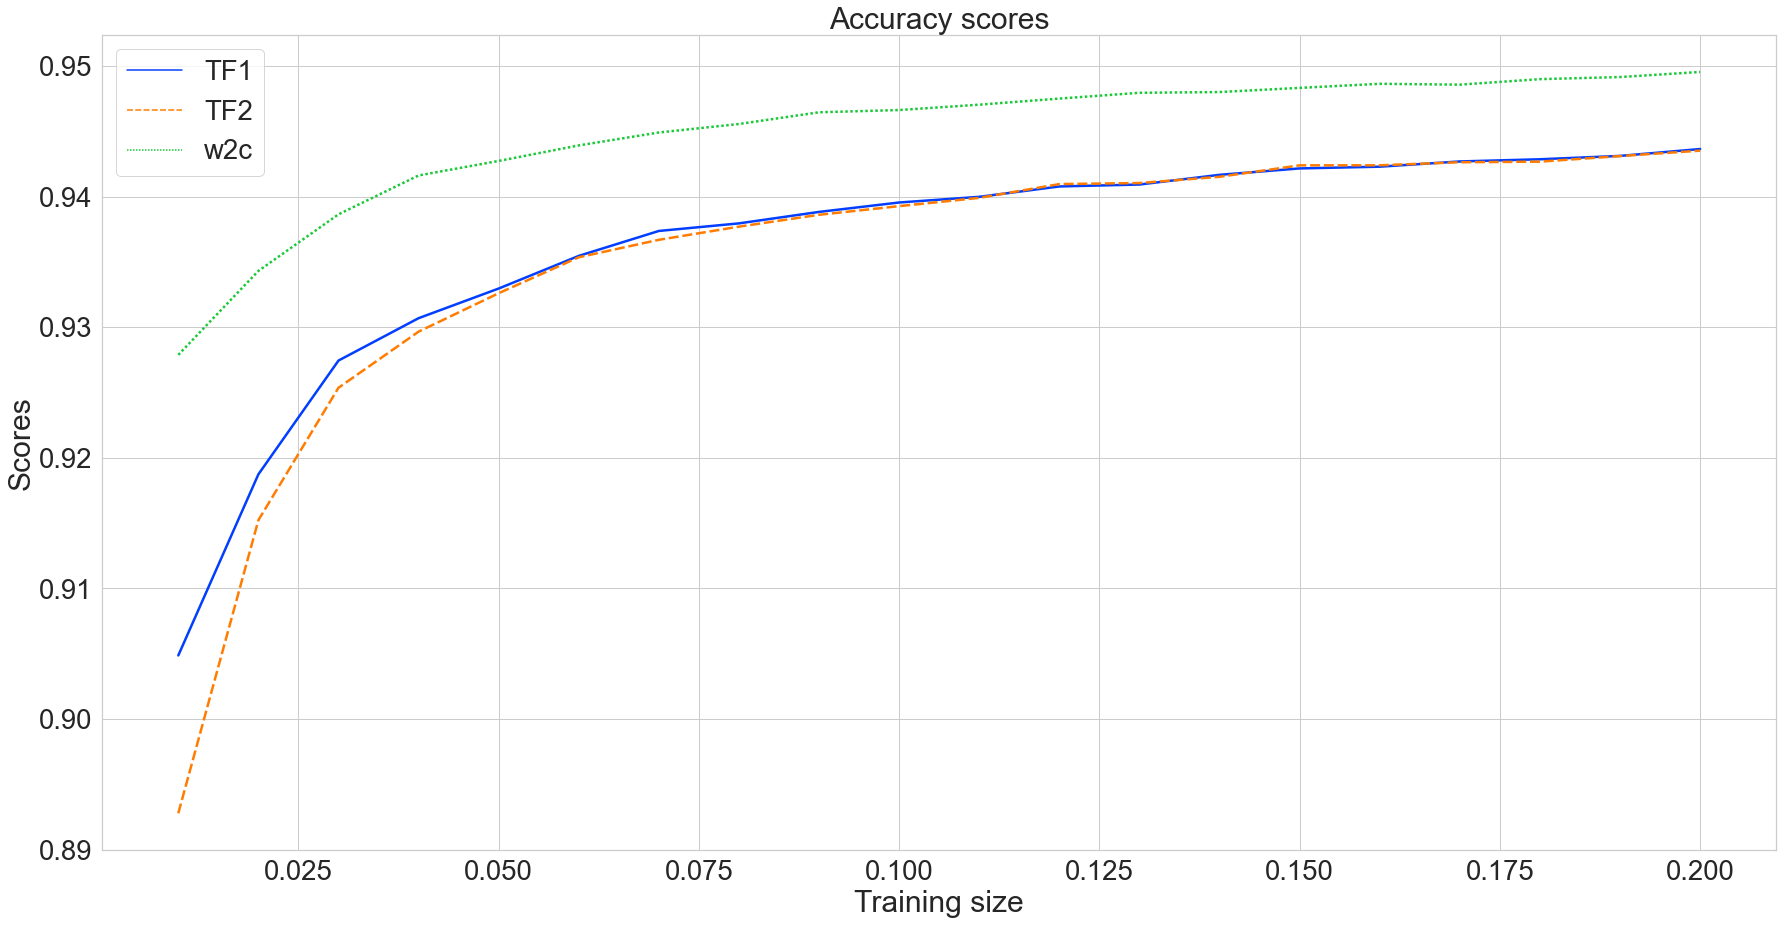

In [187]:
sns.set(style="whitegrid", font_scale=2.5)
plt.figure(figsize=(30,15))
ax = sns.lineplot(data=df, palette="bright", linewidth=2.5)
ax.set(xlabel='Training size', ylabel='Scores', title="Accuracy scores")


- With word2vec vector representation we obtain higher accuracy score than with tf representation when training dataset is small. However as we increase the size of training dataset, accuracies seem to be converging.
- Due to the limitation of computation and time, I did not fine tune proprerly the parameters of word2vec, but from observing the results of several simulations, it is reasonable to believe to accuracy of word2vec model is robust to the change of training data size.